In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np

# Step 2: Load the Dataset
df = pd.read_csv('C:/Users/jaish/Downloads/archive (7)/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Step 3: Preview Data
print(df.shape)
print(df.columns)
print(df.head())

# Step 4: Check for missing values
print(df.isnull().sum())

# Step 5: Clean 'TotalCharges' (some are empty strings, not null)
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# Step 6: Check and fix data types
print(df.dtypes)


(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# For better plot styles
sns.set(style="whitegrid")


Churn
No     5174
Yes    1869
Name: count, dtype: int64


C:\Users\jaish\AppData\Local\Temp\ipykernel_2896\204546676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='Set2')


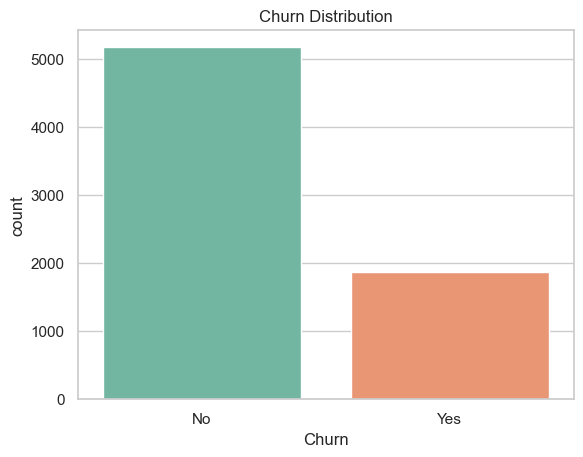

In [5]:
# Count churn values
print(df['Churn'].value_counts())

# Plot it
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title("Churn Distribution")
plt.show()


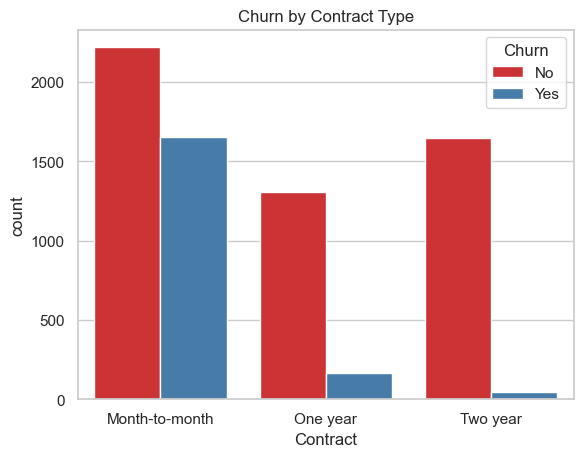

In [7]:
sns.countplot(data=df, x='Contract', hue='Churn', palette='Set1')
plt.title('Churn by Contract Type')
plt.xticks(rotation=0)
plt.show()


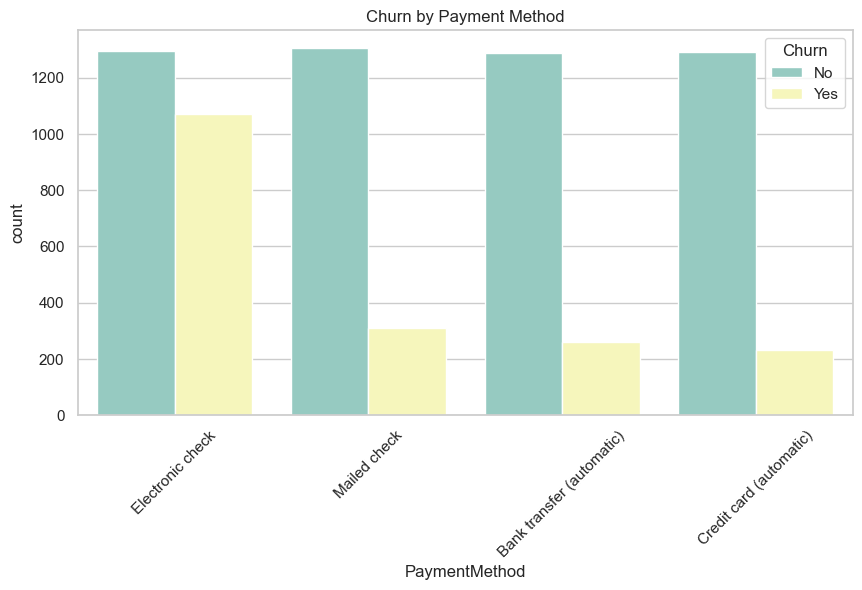

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='PaymentMethod', hue='Churn', palette='Set3')
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)
plt.show()


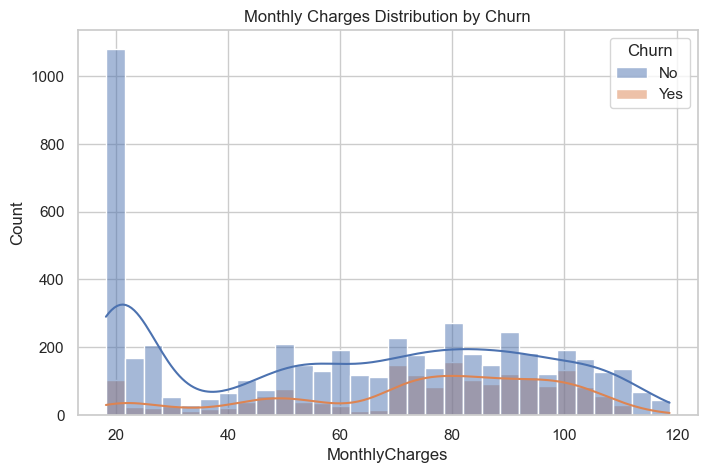

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', bins=30, kde=True)
plt.title('Monthly Charges Distribution by Churn')
plt.show()


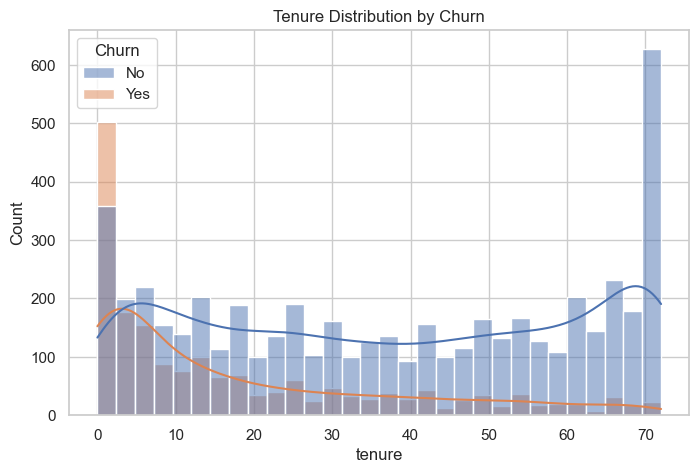

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Tenure Distribution by Churn')
plt.show()


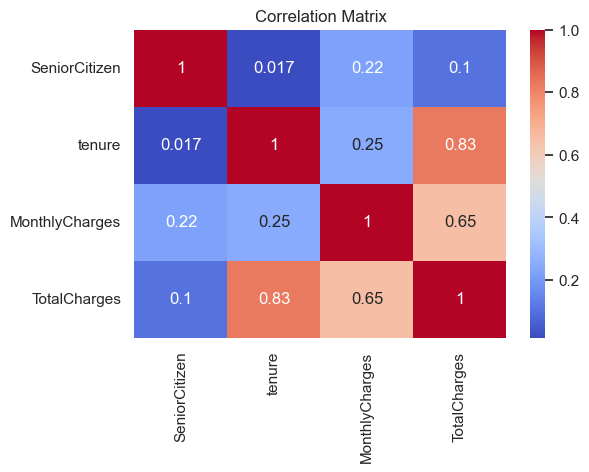

In [15]:
# Select numeric columns
numeric_df = df[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']]

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [17]:
#prep for churn hypothesis 
from scipy.stats import chi2_contingency, ttest_ind, pointbiserialr
from sklearn.preprocessing import LabelEncoder

# Encode 'Churn' to binary (Yes=1, No=0)
df['Churn_binary'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [19]:
#chi-square test
# Create contingency table
contract_churn = pd.crosstab(df['Contract'], df['Churn'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contract_churn)

print(f"Chi-square Test Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")


Chi-square Test Statistic: 1184.60
P-value: 0.0000


In [21]:
#T-Test – Do Churned Customers Have Lower Tenure?
# Separate groups
churn_yes = df[df['Churn_binary'] == 1]['tenure']
churn_no = df[df['Churn_binary'] == 0]['tenure']

# T-test
t_stat, p_value = ttest_ind(churn_yes, churn_no, equal_var=False)

print(f"T-test Statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")


T-test Statistic: -34.82
P-value: 0.0000


In [23]:
#Point Biserial Correlation – Monthly Charges vs Churn
# MonthlyCharges vs Churn
corr, pval = pointbiserialr(df['MonthlyCharges'], df['Churn_binary'])

print(f"Correlation: {corr:.2f}")
print(f"P-value: {pval:.4f}")


Correlation: 0.19
P-value: 0.0000


In [25]:
#reggretion model
#first prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Drop customerID, not useful
df_model = df.drop(['customerID', 'Churn'], axis=1)

# Encode all object columns
for column in df_model.select_dtypes(include='object').columns:
    df_model[column] = LabelEncoder().fit_transform(df_model[column])

# Features and target
X = df_model.drop('Churn_binary', axis=1)
y = df_model['Churn_binary']


In [27]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
#Build Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Build model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


C:\Users\jaish\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)



LogisticRegression(max_iter=2000)

In [35]:
#Evaluate the Model
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8161816891412349
Confusion Matrix:
 [[934 102]
 [157 216]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

